In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [2]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv',chunksize=chunksize,iterator=True,encoding='utf-8'):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
        return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [4]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [10]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

In [11]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,76249,76248,76248,0,0.599988,0.499992,0.499975,0.249994,0.571420,0.399996,...,17.703148,-43.784004,79.085964,-49.627041,10.853270,-31.774302,-58.332928,2.393426,97.718719,-12.760943
1,130411,130410,130410,0,0.714276,0.624992,0.249994,0.142855,0.461535,0.374998,...,23.430661,5.304316,0.407980,45.001185,-14.236593,-41.840542,-27.601675,-1.662045,-38.119605,-40.405542
2,141186,141185,141185,0,0.499988,0.166665,0.499988,0.153845,0.499994,0.153846,...,6.772684,-3.925592,13.487506,45.917280,32.366915,-1.286116,23.371978,-27.253523,13.517324,-9.329339
3,907475,367474,367474,0,0.499988,0.222220,0.666644,0.333328,0.499994,0.235293,...,-25.390474,-8.923546,18.393070,10.711051,-11.861647,-21.354014,-57.345053,-29.262249,-5.393539,-33.799107
4,51649,51648,51648,1,0.499975,0.499975,0.399992,0.333328,0.428565,0.374995,...,23.987352,16.199205,10.318227,13.016957,-9.500023,-18.858460,-18.510652,-11.533239,8.167423,-46.697123


In [12]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [13]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.714276,0.624992,0.249994,0.142855,0.461535,0.374998,0.0,0.0,3.0,14.5,...,23.430661,5.304316,0.407980,45.001185,-14.236593,-41.840542,-27.601675,-1.662045,-38.119605,-40.405542
2,0.499988,0.166665,0.499988,0.153845,0.499994,0.153846,0.0,1.0,18.0,17.0,...,6.772684,-3.925592,13.487506,45.917280,32.366915,-1.286116,23.371978,-27.253523,13.517324,-9.329339
3,0.499988,0.222220,0.666644,0.333328,0.499994,0.235293,0.0,1.0,9.0,12.5,...,-25.390474,-8.923546,18.393070,10.711051,-11.861647,-21.354014,-57.345053,-29.262249,-5.393539,-33.799107
4,0.499975,0.499975,0.399992,0.333328,0.428565,0.374995,0.0,1.0,1.0,7.5,...,23.987352,16.199205,10.318227,13.016957,-9.500023,-18.858460,-18.510652,-11.533239,8.167423,-46.697123
5,0.999975,0.999975,0.999975,0.799984,0.999988,0.888879,1.0,1.0,1.0,8.5,...,56.998830,34.441313,-3.105979,5.808442,-6.885805,-52.984352,-4.674659,-10.854749,34.111213,21.903769


<h2> 4.2 Converting strings to numerics </h2>

In [14]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [15]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [16]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [17]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [18]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6291285714285715 Class 1:  0.3708714285714286
---------- Distribution of output variable in test data ----------
Class 0:  0.6291333333333333 Class 1:  0.3708666666666667


In [19]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(30,8))
    sns.set_style("whitegrid")
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8817749424131083


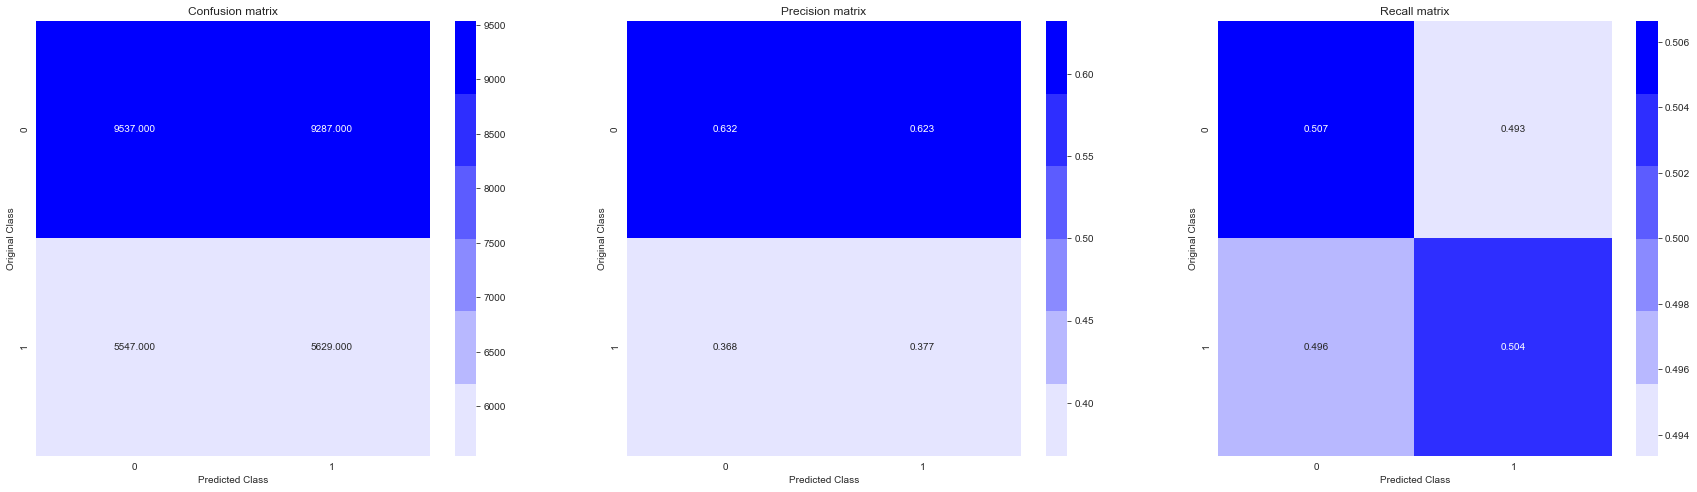

In [99]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.46259666526380994
For values of alpha =  0.0001 The log loss is: 0.4603484741104678
For values of alpha =  0.001 The log loss is: 0.4547824716470529
For values of alpha =  0.01 The log loss is: 0.4463496701257785
For values of alpha =  0.1 The log loss is: 0.453058266165249
For values of alpha =  1 The log loss is: 0.48812303138538393
For values of alpha =  10 The log loss is: 0.5312421364809576


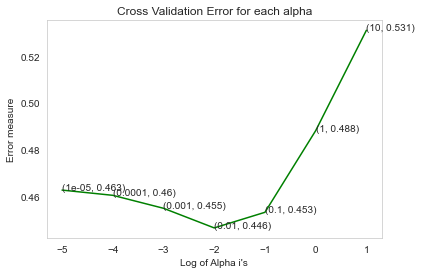

For values of best alpha =  0.01 The train log loss is: 0.4484944351893538
For values of best alpha =  0.01 The test log loss is: 0.4463496701257785
Test Accuracy score =  0.7762666666666667
Total number of data points : 30000


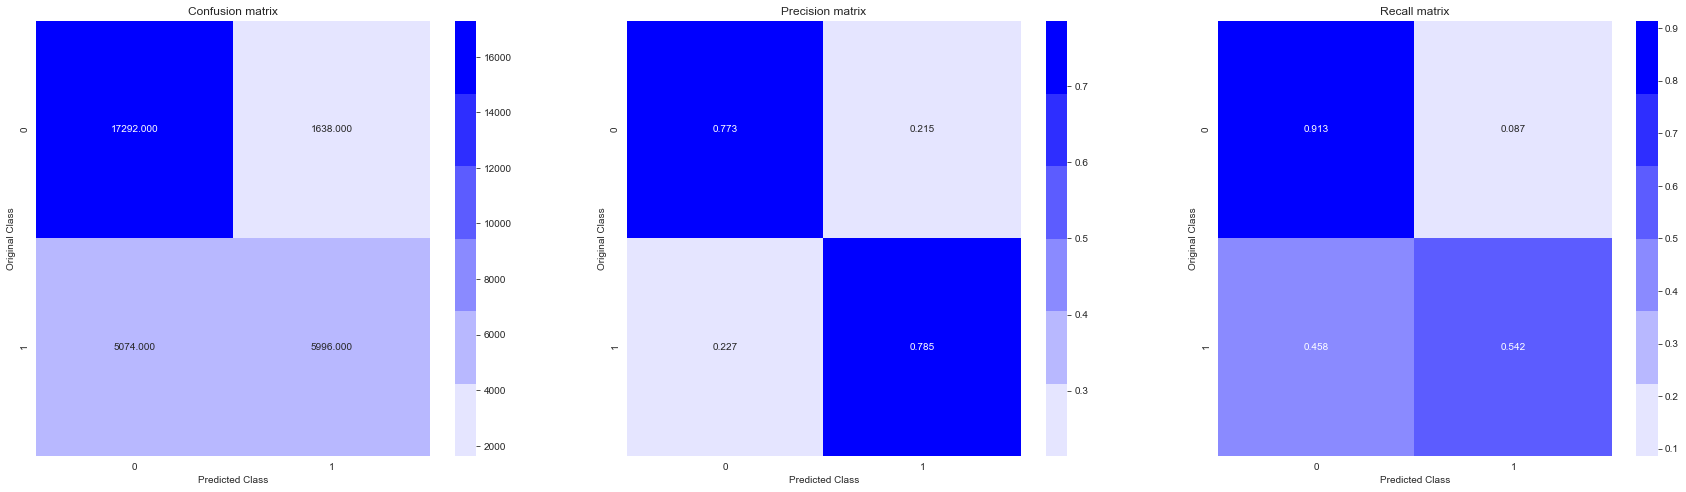

In [40]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,n_jobs = -1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate(((alpha[i]),np.round(txt,3)), (np.log10(alpha[i]),log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log of Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
y_pred = sig_clf.predict(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=[0,1], eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Test Accuracy score = ", accuracy_score(y_test,y_pred) )
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6584213183383824
For values of alpha =  0.0001 The log loss is: 0.6584213183383824
For values of alpha =  0.001 The log loss is: 0.5107804648297687
For values of alpha =  0.01 The log loss is: 0.4864748887768553
For values of alpha =  0.1 The log loss is: 0.5748232332260386
For values of alpha =  1 The log loss is: 0.6584213183383824
For values of alpha =  10 The log loss is: 0.6486286508143914


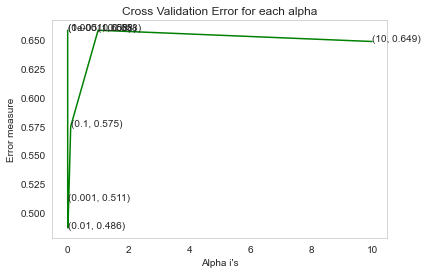

For values of best alpha =  0.01 The train log loss is: 0.48775719195177963
For values of best alpha =  0.01 The test log loss is: 0.4864748887768553
Test Accuracy Score  0.754
Total number of data points : 30000


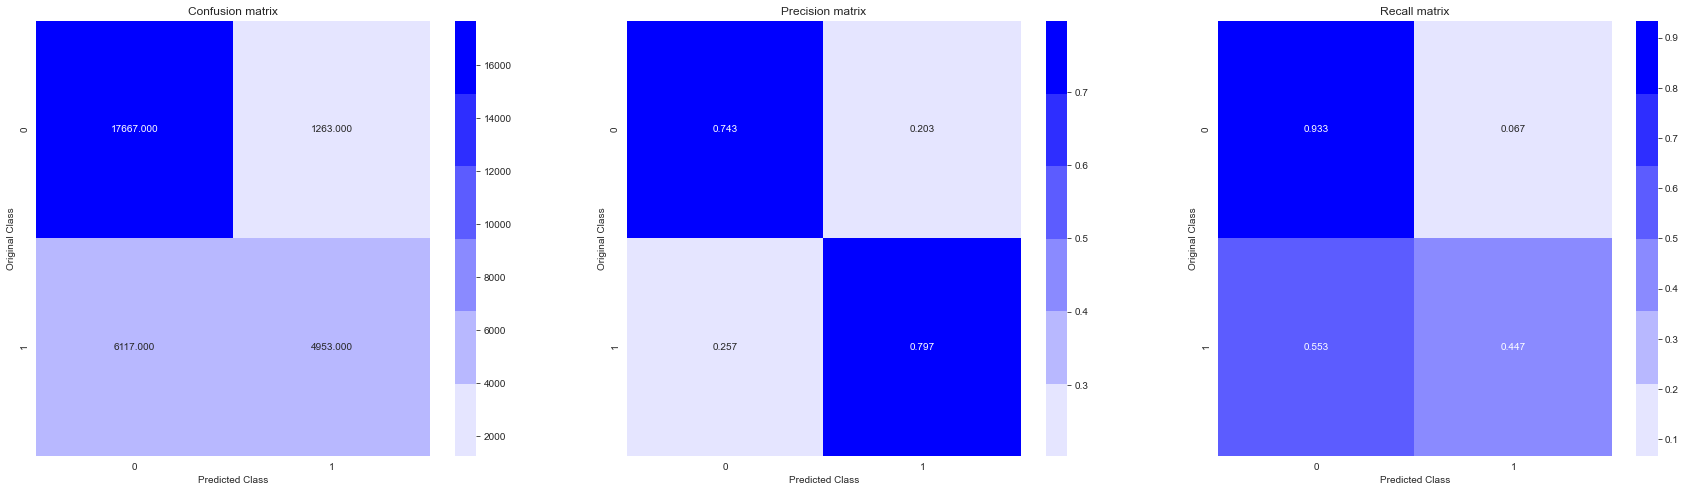

In [42]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,n_jobs = -1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (np.log10(alpha[i]),log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
y_pred = sig_clf.predict(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Test Accuracy Score ", accuracy_score(y_test,y_pred))
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [47]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))

[0]	train-logloss:0.68495	valid-logloss:0.68487
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61605	valid-logloss:0.61550
[20]	train-logloss:0.56561	valid-logloss:0.56483
[30]	train-logloss:0.52786	valid-logloss:0.52701
[40]	train-logloss:0.49903	valid-logloss:0.49815
[50]	train-logloss:0.47592	valid-logloss:0.47510
[60]	train-logloss:0.45750	valid-logloss:0.45665
[70]	train-logloss:0.44255	valid-logloss:0.44177
[80]	train-logloss:0.43108	valid-logloss:0.43037
[90]	train-logloss:0.42149	valid-logloss:0.42084
[100]	train-logloss:0.41339	valid-logloss:0.41279
[110]	train-logloss:0.40674	valid-logloss:0.40620
[120]	train-logloss:0.40103	valid-logloss:0.40054
[130]	train-logloss:0.39634	valid-logloss:0.39591
[140]	train-logloss:0.39226	valid-logloss:0.39190
[150]	train-logloss:0.38877	valid-logloss:0.38853
[160]	train-logloss:0.38575	valid-logloss:0.38567
[170]	trai

In [48]:
predict_y[0:5]

array([0.15234037, 0.36071226, 0.13698572, 0.05234868, 0.19051038],
      dtype=float32)

Total number of data points : 30000


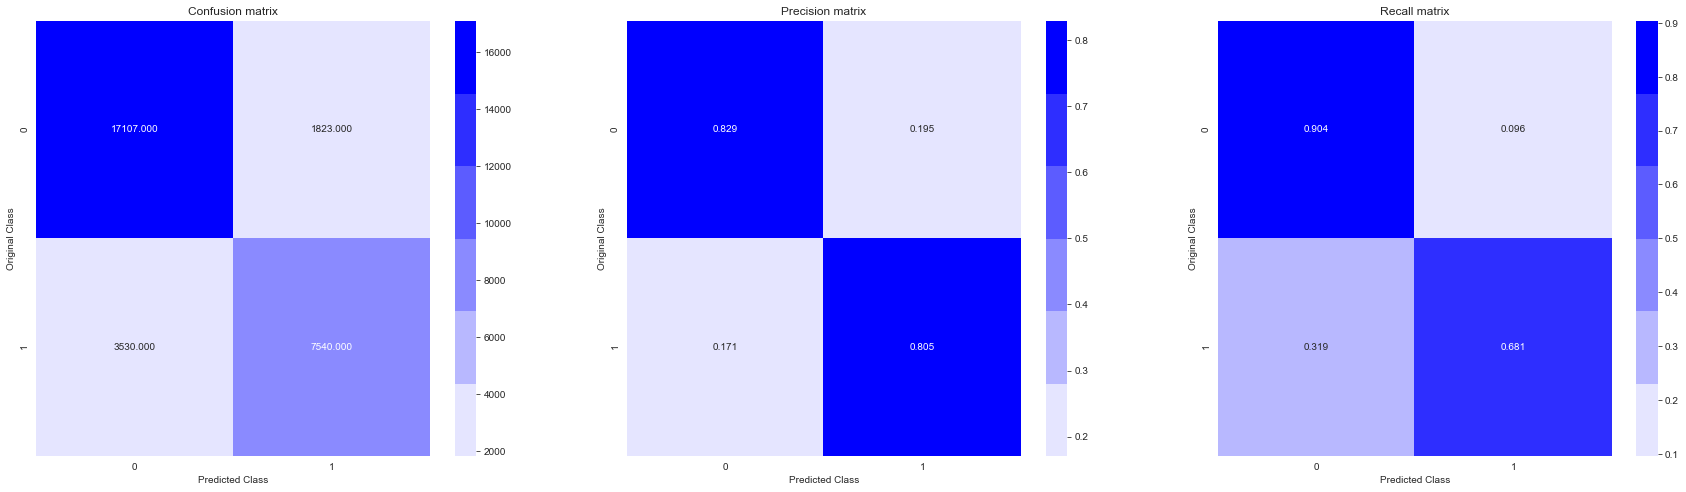

In [49]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### Tuning Gradient Boost

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [35]:
n_estimators = [100,150,200,300,400,500,600,700,800]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.5, 0.7 , 0.9, 1]
subsample = [0.5,0.7,0.9,1]
max_depth = [1,2,5,10,15,20]
y_train = np.array(y_train)
def boosting(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample,max_depth = max_depth)
    
    model = XGBClassifier(n_jobs = -1)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=1)
    random_result = random_search.fit(X,Y)
    
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):    
        print("%f (%f) with: %r" % (mean, stdev, param))
  


In [36]:
boosting(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: -0.340850 using {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}

-0.441272 (0.001356) with: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
-0.589790 (0.000597) with: {'subsample': 1, 'n_estimators': 700, 'max_depth': 1, 'learning_rate': 0.001, 'colsample_bytree': 0.5}
-0.458789 (0.003373) with: {'subsample': 0.7, 'n_estimators': 600, 'max_depth': 20, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
-0.340850 (0.001675) with: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1}
nan (nan) with: {'subsample': 0.5, 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.9}
-0.648811 (0.000276) with: {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.001, 'colsample_bytree': 0.7}
-0.402868 (0.000444) with: {'subsample': 0.5, 'n_estimators': 150, 'max_depth': 15, 'learning_rate': 0.0

In [66]:
start = dt.datetime.now()
model = XGBClassifier(subsample = 0.9,booster = 'gbtree', n_estimators =  200, max_depth =  5, learning_rate = 0.1, colsample_bytree = 1 ,n_jobs = -1)
model.fit(X_train,y_train)
print("time taken :",(dt.datetime.now()-start))
train_proba  = model.predict_proba(X_train)[:,1]
test_proba = model.predict_proba(X_test)[:,1]
print("Train Logloss %f  Test Logloss %f"%(log_loss(y_train, train_proba),log_loss(y_test,test_proba)))

time taken : 0:03:43.517360
Train Logloss 0.282097  Test Logloss 0.334896


In [67]:
print("Test Accuracy is ", accuracy_score(y_test,model.predict(X_test)))
print("Train Accuracy is ", accuracy_score(y_train,model.predict(X_train)))

Test Accuracy is  0.8356
Train Accuracy is  0.876


### [4.7] LightGBM

In [76]:
from lightgbm import LGBMClassifier
start = dt.datetime.now()
model = LGBMClassifier(subsample = 0.9 ,booster = 'gbtree', n_estimators = 200, max_depth =  4, learning_rate = 0.1, colsample_bytree = 1 ,n_jobs = -1)
model.fit(X_train,y_train)
print("time taken :",(dt.datetime.now()-start))
train_proba  = model.predict_proba(X_train)[:,1]
test_proba = model.predict_proba(X_test)[:,1]
print("Train Logloss %f  Test Logloss %f"%(log_loss(y_train, train_proba),log_loss(y_test,test_proba)))

time taken : 0:00:08.848671
Train Logloss 0.313424  Test Logloss 0.340294


## [5]Using Simple TFIDF Vectors

In [50]:
df1 = pd.read_csv("final_features.csv",nrows = 100000)

In [59]:
for i in range(0,96):
    df1.drop([str(i)+'_x',str(i)+'_y'],inplace = True,axis = 1)


In [69]:
target = df1.is_duplicate
df1.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
df1.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [75]:
df = pd.read_csv('nlp_features_train.csv',nrows = 100000,encoding = 'latin1')
df.fillna('')
question_1 = df['question1']
question_2 = df['question2']

In [79]:
question_1.values

array(['what is the step by step guide to invest in share market in india ',
       'what is the story of kohinoor  koh i noor  diamond ',
       'how can i increase the speed of my internet connection while using a vpn ',
       ..., 'who would win  black panther or batman ',
       'which school is better  for what  and why  parsons or risd ',
       'how does human body produce carbon dioxide '], dtype=object)

In [81]:
tfidf = TfidfVectorizer()
x_train_tfidf = tfidf.fit_transform((question_1).apply(lambda x: np.str_(x)))
x_test_tfdif = tfidf.fit_transform((question_2).apply(lambda x: np.str_(x)))

In [85]:
print(x_train_tfidf.shape)
print(x_test_tfdif.shape)

(100000, 36418)
(100000, 33960)


In [87]:
final_train = hstack((df1,x_train_tfidf,x_test_tfdif), format = 'csr', dtype='float64')

In [91]:
final_train.shape

(100000, 70404)

### [5.2]Splitting into Train and Test (70:30)

In [89]:
x_train,x_test,y_train,y_test = train_test_split(final_train,target,stratify = target, test_size = 0.3)

In [90]:
print(type(x_train))

<class 'scipy.sparse.csr.csr_matrix'>


### [5.3] Applying ML Models

### [5.3.1] Applying Random model (for worst case)

Log loss on Test Data using Random Model 0.8879749803078737


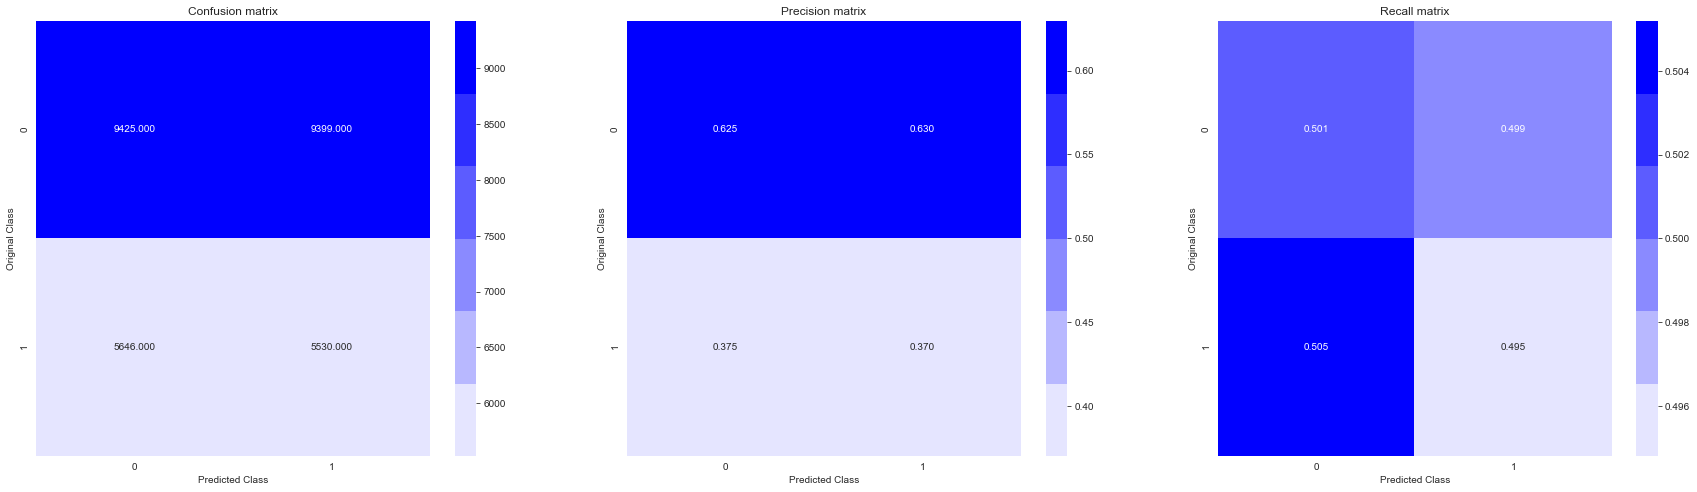

In [103]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### [5.3.2] Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.4272233378268851
For values of alpha =  0.0001 The log loss is: 0.41656832796651816
For values of alpha =  0.001 The log loss is: 0.418255352983905
For values of alpha =  0.01 The log loss is: 0.4441613709925832
For values of alpha =  0.1 The log loss is: 0.46093620932492585
For values of alpha =  1 The log loss is: 0.49007407914360984
For values of alpha =  10 The log loss is: 0.5417559058228409


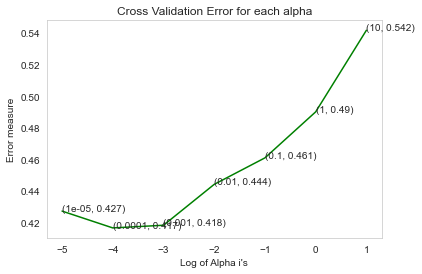

For values of best alpha =  0.0001 The train log loss is: 0.4120300025490594
For values of best alpha =  0.0001 The test log loss is: 0.41656832796651816
Test Accuracy score =  0.7944666666666667
Total number of data points : 30000


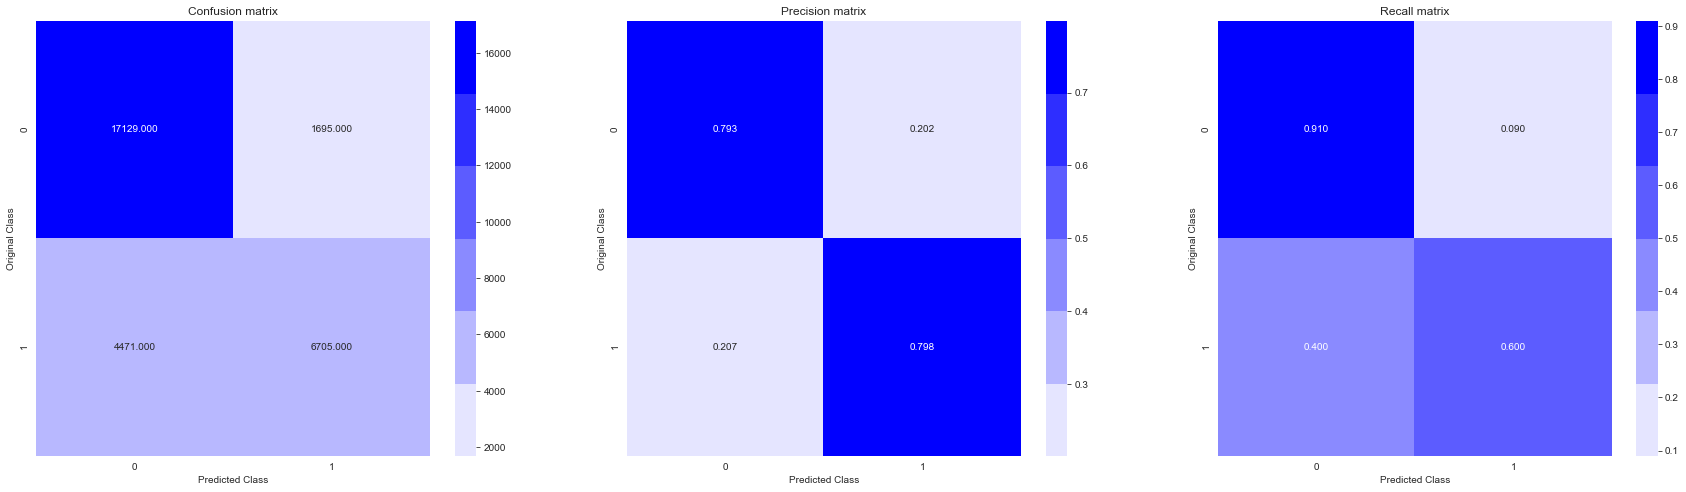

In [106]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,n_jobs = -1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate(((alpha[i]),np.round(txt,3)), (np.log10(alpha[i]),log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log of Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
y_pred = sig_clf.predict(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=[0,1], eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Test Accuracy score = ", accuracy_score(y_test,y_pred) )
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

### [5.3.3] Linear SVM

For values of alpha =  1e-07 The log loss is: 0.6602902109101162
For values of alpha =  1e-06 The log loss is: 0.41054070561422723
For values of alpha =  1e-05 The log loss is: 0.4049926467748375
For values of alpha =  0.0001 The log loss is: 0.4231202005360965
For values of alpha =  0.001 The log loss is: 0.422246850958014
For values of alpha =  0.01 The log loss is: 0.44382133566495746
For values of alpha =  0.1 The log loss is: 0.4599612743604393
For values of alpha =  1 The log loss is: 0.4780006050860643
For values of alpha =  10 The log loss is: 0.5360555019317856


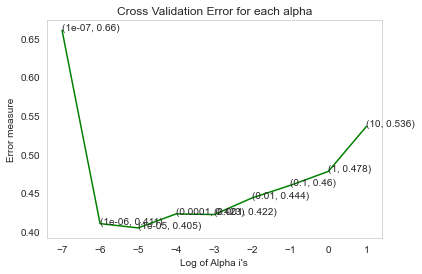

For values of best alpha =  1e-05 The train log loss is: 0.40013421723467796
For values of best alpha =  1e-05 The test log loss is: 0.4049926467748375
Test Accuracy score =  0.7998666666666666
Total number of data points : 30000


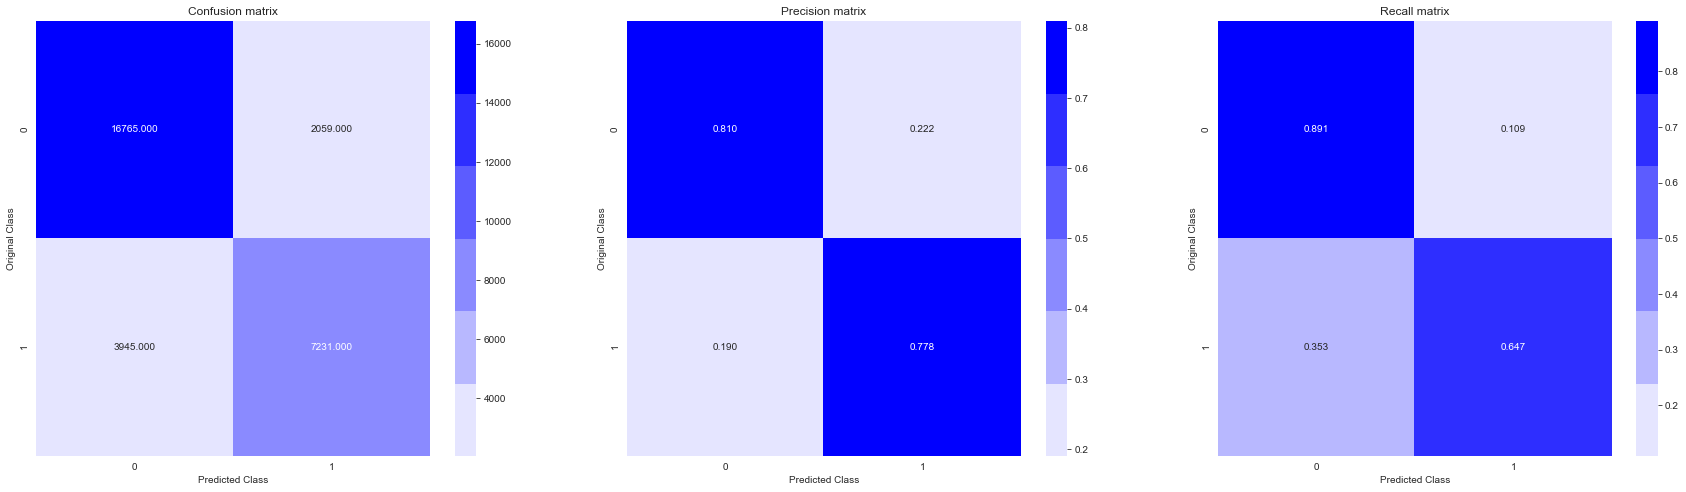

In [109]:
alpha = [10 ** x for x in range(-7, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42,n_jobs = -1)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))

sns.set_style("whitegrid")
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate(((alpha[i]),np.round(txt,3)), (np.log10(alpha[i]),log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Log of Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
y_pred = sig_clf.predict(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=[0,1], eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Test Accuracy score = ", accuracy_score(y_test,y_pred) )
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Conclusion

In [78]:
import prettytable
table = prettytable.PrettyTable()
table.field_names = ["Model", "Vectorizer", "Best Hyperparameters","Log loss"]
table.add_row(["Random", "TFIDF weighted Word vectors", None,0.881774])
table.add_row(["Logistic Regression", "TFIDF weighted Word vectors", "alpha = 0.01",0.446349])
table.add_row(["Linear SVM", "TFIDF weighted Word vectors","alpha = 0.01",0.486474])
table.add_row(["XGBoost", "TFIDF weightted Word vectors", "eta = 0.02, max_depth = 4, n_estimators = 400",0.357432])
table.add_row(["XGBoost", "TFIDF weightted Word vectors", "subsample:0.9, n_estimators:200, max_depth:5, eta:0.1",0.334896])
table.add_row(["Logistic Regression", "TFIDF","aplha = 0.0001",0.416568])
table.add_row(["Linear SVM", "TFIDF", "alpha = 0.00001",0.404992])
table.add_row(["LightGBM", "TFIDF weightted Word vectors", "subsample = 0.9,eta = 0.1, max_depth = 4, n_estimators = 200",0.340294])

print(table)

+---------------------+------------------------------+--------------------------------------------------------------+----------+
|        Model        |          Vectorizer          |                     Best Hyperparameters                     | Log loss |
+---------------------+------------------------------+--------------------------------------------------------------+----------+
|        Random       | TFIDF weighted Word vectors  |                             None                             | 0.881774 |
| Logistic Regression | TFIDF weighted Word vectors  |                         alpha = 0.01                         | 0.446349 |
|      Linear SVM     | TFIDF weighted Word vectors  |                         alpha = 0.01                         | 0.486474 |
|       XGBoost       | TFIDF weightted Word vectors |        eta = 0.02, max_depth = 4, n_estimators = 400         | 0.357432 |
|       XGBoost       | TFIDF weightted Word vectors |    subsample:0.9, n_estimators:200, max_de